# NDVI Phenology

This notebook calculates vegetation phenology changes using Landsat-7 and/or Landsat-8 data. To detect changes in plant life, the algorithm uses the Normalized Difference Vegetation Index (NDVI) as this is a common proxy for vegetation growth and health. The output from this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.  
<br>
The output product is a statistical time series plot of NDVI with the data "binned" into weeks or months. The timeline can be changed from a single year (all data binned with the 12-month period) or spread out over the entire time window of the analyses. 
<br><br>
See this website for more information: https://phenology.cr.usgs.gov/ndvi_foundation.php

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app')#, config = '/home/localuser/.datacube.conf')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np  
import xarray as xr  
import pandas as pd
import datetime as dt

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()#config = '/home/localuser/.datacube.conf')

In [2]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>
output_crs = 'EPSG:4326'
resolution = (-0.000269494585236, 0.000269494585236)

# It is possible to select ONE or BOTH of the datasets (L7 and L8)
# True = SELECT
# False = DO NOT SELECT

use_Landsat7 = True
use_Landsat8 = True

platforms = []
products = []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_collection1_AMA_ingest')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_collection1_AMA_ingest')

## Define the Extents of the Analysis and Visualize the Region

In [3]:
## LS8 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '2013-04-13', '2018-03-26'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS8 Vietnam
# Latitude:  (10.513927001104687, 12.611133863411238)  
# Longitude: (106.79005909290998, 108.91906631627438)  
# '2014-01-14', '2016-12-21'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '1999-08-21', '2018-03-25'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Lake Baringo
# Latitude:  (0.4997747685, 0.7495947795)  
# Longitude: (35.9742163305, 36.473586859499996)  
# '2005-01-08', '2016-12-24'
# Resolution: (-0.000269493, 0.000269493)

In [4]:
# CHANGE HERE >>>>>>>>>>>>>>>

# Select a subset of the time bounds available in the cube(s)
# Specify latitude and longitude bounds of an analysis area within the full extents

#Sub-region selection - e.g Vietnam
#latitude = (11.3124, 10.9124)
#longitude = (106.9170, 107.3170) 
#time_extents = ('2014-01-01', '2016-01-01')

#Sub-region selection - e.g Lake Baringo
latitude  = (0.49964002, 0.74964002)
longitude = (36.0, 36.3)
time_extents = ('2007-01-01', '2010-01-01')

In [5]:
# Visualize the analysis region

from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_display_map import display_map

display_map(latitude, longitude)

## Load Data from the Data Cube, Remove Clouds, and Calculate NDVI

It should be noted that the next step can take some time as the algorithm can be loading two datasets.

In [6]:
from utils.data_cube_utilities.dc_load import load_multiplatform

measurements = ['red', 'blue', 'green', 'nir', 'swir1', 'swir2', 'pixel_qa']
dataset, clean_mask, _ = \
    load_multiplatform(dc, platforms, products, 
                       load_params=dict(lat=latitude, lon=longitude, time=time_extents,
                                        measurements=measurements, output_crs=output_crs, resolution=resolution))
cleaned_dataset = dataset.where(clean_mask)
del dataset

In [7]:
from utils.data_cube_utilities.dc_ndvi_anomaly import NDVI
ndvi_arr = NDVI(cleaned_dataset)
cleaned_dataset['ndvi'] = ndvi_arr

## Create the NDVI Phenology Product

If no plots appear in the figures below, there is no data available for the region selected.

In [8]:
# Create an NDVI Box-and-Whisker Phenology plot

from utils.data_cube_utilities.plotter_utils import xarray_time_series_plot

# CHANGE HERE >>>>>>>>>>>>>>>

# Specify whether to plot a Gaussian curve fit of the mean of NDVI along time.
# True = Plot the Guassian Fit
# False = DO NOT Plot the Gaussian Fit

plot_curve_fit_ndvi_mean = True

max_times_per_plot = 10 # The maximum number of acquisitions with data that appear in each plot.

NDVI (Aggregated by Month)


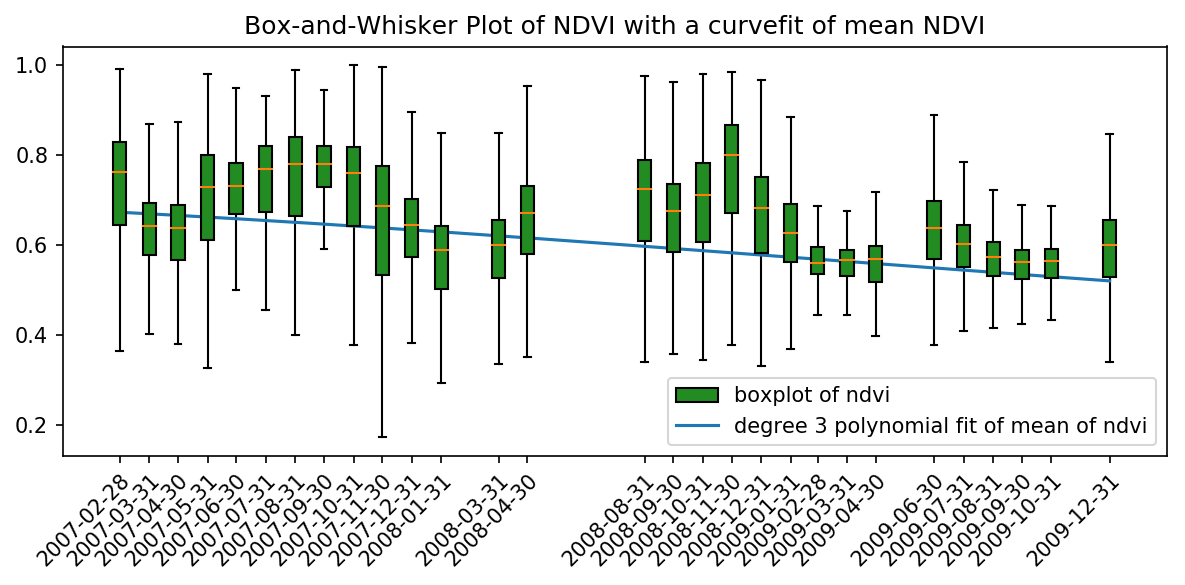

In [9]:
# CHANGE HERE >>>>>>>>>>>>>>

# Select the binning approach for the NDVI data. Change the first parameter (Red, in quotes)
# week = bin the data by week with an extended time axis
# month = bin the data by month with an extended time axis
# weekofyear = bin the data by week and years using a single year time axis
# monthofyear = bin the data by month and years using a single year time axis

# It is also possible to change some of the plotting features using the code below

for bin_by in ['month']:
    aggregated_by_str = None
    if bin_by is None:
        plotting_data = cleaned_dataset
    elif bin_by == 'week':
        plotting_data = cleaned_dataset.resample(time='1w').mean()
        aggregated_by_str = 'Week'
    elif bin_by == 'month':
        plotting_data = cleaned_dataset.resample(time='1m').mean()
        aggregated_by_str = 'Month'
    elif bin_by == 'weekofyear':
        plotting_data = cleaned_dataset.groupby('time.week').mean(dim=('time'))
        aggregated_by_str = 'Week of Year'
    elif bin_by == 'monthofyear':
        plotting_data = cleaned_dataset.groupby('time.month').mean(dim=('time'))
        aggregated_by_str = 'Month of Year'
    
params = dict(dataset=plotting_data, plot_descs={'ndvi':{'none':[
    {'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})
if plot_curve_fit_ndvi_mean:
    params['plot_descs']['ndvi']['mean'] = [{'poly': {'degree': 3}}]
    
params['scale_params'] = 'norm'
    
xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150))
plt.title('Box-and-Whisker Plot of NDVI with a curvefit of mean NDVI')
print("NDVI {}".format("(Aggregated by {})".format(aggregated_by_str) if aggregated_by_str is not None else ""))